In [184]:
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.datasets import imdb

import pandas as pd
import numpy as np

%matplotlib inline

In [185]:
data = pd.read_csv("bf_classify_v5.csv")

labels = []
for _,row in data.iterrows():
    if row['score']  > 0 :
        labels.append('Tip')
    elif row['score']  < 0:
        labels.append('notTip')
    else:
        labels.append('Unknown')


In [186]:
data['label'] = labels
data.columns

Index(['CPSC.Case..', 'trmt_date', 'psu', 'weight', 'stratum', 'age', 'sex',
       'race', 'race_other', 'diag', 'diag_other', 'body_part', 'disposition',
       'location', 'fmv', 'prod1', 'prod2', 'narr1', 'narr2', 'Narra', 'year',
       'score', 'label'],
      dtype='object')

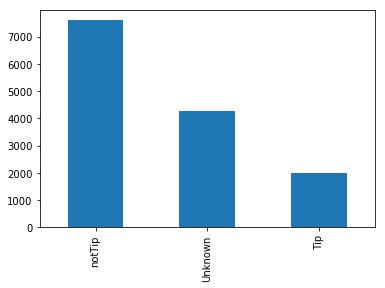

In [187]:
data.label.value_counts().plot(kind='bar')

In [188]:
data.label.value_counts()

notTip     7593
Unknown    4269
Tip        2001
Name: label, dtype: int64

In [189]:
from string import punctuation
import re

incidents = []

regex = re.compile('[%s]' % re.escape(punctuation))

for index, row in data.iterrows():
    out = regex.sub(' ', row['Narra'])
    incidents.append(out)


In [190]:
np.array(incidents[0:5])

array(['28 YOM FELT SNAP IN WRIST WHILE LIFTING ARMOIREWRIST SPRAIN',
       '40 YOM WAS MOVING ARMOIRE DOWNSTAIRS WHEN ARMOIRE SLIPPED AND PINNEDPT AGAINST THE WALL  DX RIB FX',
       '2 YOF INJURED HEAD AND TOOTH FROM ARMOIRE FALLING ON HER  DX CLOSED HEAD INJURY',
       '3YOF CLIMBING ON DRESSER ARMOIRE',
       'DX THUMB PN  23YOF MOVING ARMOIRE INTO HOME'], 
      dtype='<U98')

In [191]:
from collections import Counter

total_counts = Counter()

for row in incidents:
        total_counts.update(row.split(" "))

print("Total words in data set: ", len(total_counts))

Total words in data set:  6174


In [192]:
vocab = sorted(total_counts, key=total_counts.get, reverse=True)[:10000]
print(vocab[:60])

['', 'DRESSER', 'ON', 'FELL', 'A', 'AND', 'HEAD', 'DX', 'HIT', 'OF', 'TO', 'CHEST', 'HOME', 'AT', 'BED', 'CONTUSION', 'THE', 'PAIN', 'LAC', 'LACERATION', 'YOF', 'WAS', 'HITTING', 'YOM', 'PT', 'YO', 'WHEN', 'BACK', 'FACE', 'MOVING', 'FOOT', 'OFF', 'INJURY', 'O', 'INTO', 'HER', 'TOE', 'AGAINST', 'HAND', 'IN', 'SCALP', 'F', 'OUT', 'STRUCK', 'WITH', 'M', 'ONTO', 'FX', 'FOREHEAD', 'DRAWER', 'WHILE', 'AFTER', 'MALE', 'YR', 'FROM', 'CORNER', 'TRIPPED', 'FEMALE', '2', 'OLD']


In [193]:
word2idx = {word: i for i, word in enumerate(vocab)}
list(word2idx.items())[0:20]

[('', 0),
 ('AREA', 239),
 ('DIP', 2984),
 ('22YF', 2141),
 ('THROUGH', 637),
 ('HEARING', 1757),
 ('PICKINGUP', 2138),
 ('DVD', 1264),
 ('ANDIT', 5518),
 ('ANDDEVELOPED', 2987),
 ('RUSTY', 2139),
 ('PLUGGING', 2988),
 ('SHLDR', 1356),
 ('BEAME', 2989),
 ('FINGERS', 892),
 ('REDNESS', 1265),
 ('PNEUMOMEDIASTINUM', 2990),
 ('COT', 2140),
 ('BURSITIS', 2985),
 ('BEHINDTHE', 2991)]

In [194]:
def text_to_index(text):
    word_vector= []
    
    for word in text.split(' '):
        idx = word2idx.get(word,None)
        word_vector.append(idx)
    return word_vector

In [195]:
text_to_index("28 YOM FELT SNAP IN WRIST WHILE LIFTING ARMOIREWRIST SPRAIN")

[316, 23, 193, 1797, 39, 103, 50, 102, 5021, 107]

In [196]:
text_to_index("3YOF CLIMBING ON DRESSER ARMOIRE")

[168, 87, 2, 1, 296]

In [197]:
incidentsIdx = []

for row in incidents:
        incidentsIdx.append(text_to_index(row))

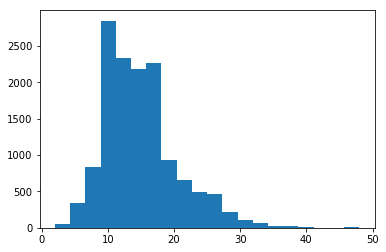

In [198]:
len_indx = []
for row in incidentsIdx:
    len_indx.append(len(row))

from matplotlib import pyplot as plt
plt.hist(len_indx, bins=20,)
plt.show()

In [199]:
unknownIdx = []
train = []
target = []
for x, y in zip(incidentsIdx, labels):
    if(y == 'Unknown'):
        unknownIdx.append(x)
    else:
        train.append(x)
        target.append(y)    

In [200]:
Y = list([1 if each == 'Tip' else 0 for each in target])

In [201]:
len(Y)

9594

In [202]:
len(train)

9594

In [203]:
from sklearn.model_selection import train_test_split

trainX,testX,trainY,testY = train_test_split(train, Y, test_size=0.2, random_state=42)

In [204]:
# Data preprocessing
# Sequence padding
trainX = pad_sequences(trainX, maxlen=40, value=0.)
testX = pad_sequences(testX, maxlen=40, value=0.)
# Converting labels to binary vectors
trainY = to_categorical(trainY, nb_classes=2)
testY = to_categorical(testY, nb_classes=2)

# RNN
# Network building
>net = tflearn.input_data([None, 30])

>net = tflearn.embedding(net, input_dim=10000, output_dim=128)

>net = tflearn.lstm(net, 64, dropout=0.8)

>net = tflearn.fully_connected(net, 2, activation='softmax')

>net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

In [205]:
# Network building

tf.reset_default_graph()

net = tflearn.input_data([None, 40])
net = tflearn.embedding(net, input_dim=10000, output_dim=128)
net = tflearn.lstm(net, 64, dropout=0.8)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

In [206]:
# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True,
          batch_size=32, n_epoch=10)

Training Step: 2399  | total loss: 0.04217 | time: 15.877s
| Adam | epoch: 010 | loss: 0.04217 - acc: 0.9882 -- iter: 7648/7675
Training Step: 2400  | total loss: 0.03866 | time: 16.958s
| Adam | epoch: 010 | loss: 0.03866 - acc: 0.9894 | val_loss: 0.20475 - val_acc: 0.9489 -- iter: 7675/7675
--


In [207]:
predictions = (np.array(model.predict(testX))[:,0] >= 0.5).astype(np.int_)
test_accuracy = np.mean(predictions == testY[:,0], axis=0)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.948931735279


In [208]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions, testY[:,0], labels = [0,1])
cm

array([[ 341,   54],
       [  44, 1480]])

In [209]:
tp = float(cm[0][0])/np.sum(cm[0])
tn = float(cm[1][1])/np.sum(cm[1])

print(tp)
print(tn)



0.863291139241
0.971128608924


# Try My Own Sentense!

In [210]:
# Helper function that uses your model to predict sentiment
def test_sentence(sentence):
    positive_prob = model.predict(pad_sequences([text_to_index(sentence)], maxlen=40, value=0.))[0][1]
    print('Sentence: {}'.format(sentence))
    print('P(positive) = {:.3f} :'.format(positive_prob), 
          'Tip' if positive_prob > 0.5 else 'Not tip')

In [211]:
sentence = "2 YO FEMALE SHUT FINGER IN A BUREAU  DX FINGER LACERATION"
test_sentence(sentence)

Sentence: 2 YO FEMALE SHUT FINGER IN A BUREAU  DX FINGER LACERATION
P(positive) = 0.004 : Not tip


In [212]:
sentence = "39 Y O M LACERATED FACE WHEN HE STRUCK A BUREAU WHILE SLEEP WALKING"
test_sentence(sentence)

Sentence: 39 Y O M LACERATED FACE WHEN HE STRUCK A BUREAU WHILE SLEEP WALKING
P(positive) = 0.002 : Not tip


In [213]:
sentence = "10YOM FELL INTO DRESSOR"
test_sentence(sentence)

Sentence: 10YOM FELL INTO DRESSOR
P(positive) = 0.004 : Not tip


In [214]:
sentence = "DRESSER FELL ON TO 3YOM"
test_sentence(sentence)

Sentence: DRESSER FELL ON TO 3YOM
P(positive) = 0.946 : Tip


# Apply to Unknown

In [215]:
positive_prob = []
predicted_label = []
for i in unknownIdx:
    prob = model.predict(pad_sequences([i], maxlen=40, value=0.))[0][1]
    positive_prob.append(prob) 
    predicted_label.append('Tip over' if prob > 0.5 else 'Not tip over')

In [216]:
df_result = pd.DataFrame({
                'tipover prob': positive_prob,
                'predicted label': predicted_label,
                'unknownIdx': unknownIdx
             })

In [218]:
df_result.to_csv("result.csv")